Data overview

In [31]:
import numpy as np
import pandas as pd
import scipy
import scipy.signal
import datetime
import matplotlib
import matplotlib.pyplot as plt
import tqdm
import random
import os
import glob
from pathlib import Path


In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [49]:
#Defines
#/drive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe
train_csv_path = "./gdrive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/train.csv"
sample_csv_path = "./gdrive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/sample_submission.csv"
single_segment = "./gdrive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/train/1003520023.csv"
train_data_path = "./gdrive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/train/"
test_data_path = "./gdrive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/test/"
sample_size = 10


In [7]:
train = pd.read_csv(train_csv_path)
sample_submission = pd.read_csv(sample_csv_path)


In [ ]:
# Convert 'time_to_eruption'to hours:minutes:seconds (Just for reference)
#train['days_hours_minutes_seconds'] = (train['time_to_eruption']
             #     .apply(lambda x:datetime.timedelta(seconds = x/100))) 100???? why


In [8]:
train


,segment_id,time_to_eruption
0,1136037770,12262005
1,1969647810,32739612
2,1895879680,14965999
3,2068207140,26469720
4,192955606,31072429
...,...,...
4426,873340274,15695097
4427,1297437712,35659379
4428,694853998,31206935
4429,1886987043,9598270


In [9]:
train['time_to_eruption'].describe()


count    4.431000e+03
mean     2.284891e+07
std      1.348439e+07
min      6.250000e+03
25%      1.127016e+07
50%      2.246559e+07
75%      3.434356e+07
max      4.904609e+07
Name: time_to_eruption, dtype: float64

In [10]:
print('Median:', train['time_to_eruption'].median())
print('Skew:', train['time_to_eruption'].skew()) #symetric?
print('Std:', train['time_to_eruption'].std())
print('Kurtosis:', train['time_to_eruption'].kurtosis()) #heavy-tailed?
print('Mean:', train['time_to_eruption'].mean())

Median: 22465586.0
Skew: 0.059347778798359965
Std: 13484385.863632679
Kurtosis: -1.166601027916375
Mean: 22848906.832769126


In [ ]:
sample_submission

In [ ]:
# From DF to Dic for O(1) access
train_dic = dict(zip(train.segment_id, train.time_to_eruption))
train_dic

Look on single segment


In [12]:
segment = pd.read_csv(single_segment,dtype ="int16")
segment.describe()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
count,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000
mean,-2.655972,2.833653,-2.042849,4.328478,-1.122381,3.244479,-0.003517,0.566857,-3.991817,-6.967667
std,352.515183,505.483617,1688.145155,373.274112,203.377615,613.783446,606.808575,672.314475,330.512391,758.130409
min,-1698.000000,-6830.000000,-32767.000000,-1747.000000,-1229.000000,-2592.000000,-2390.000000,-2529.000000,-2022.000000,-2815.000000
25%,-236.000000,-286.000000,-339.000000,-242.000000,-131.000000,-419.000000,-401.000000,-454.000000,-220.000000,-502.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,235.000000,294.000000,332.000000,249.000000,128.000000,427.000000,395.000000,461.000000,210.000000,492.000000
max,1407.000000,6472.000000,32767.000000,1955.000000,1354.000000,2101.000000,3051.000000,3144.000000,1306.000000,4018.000000


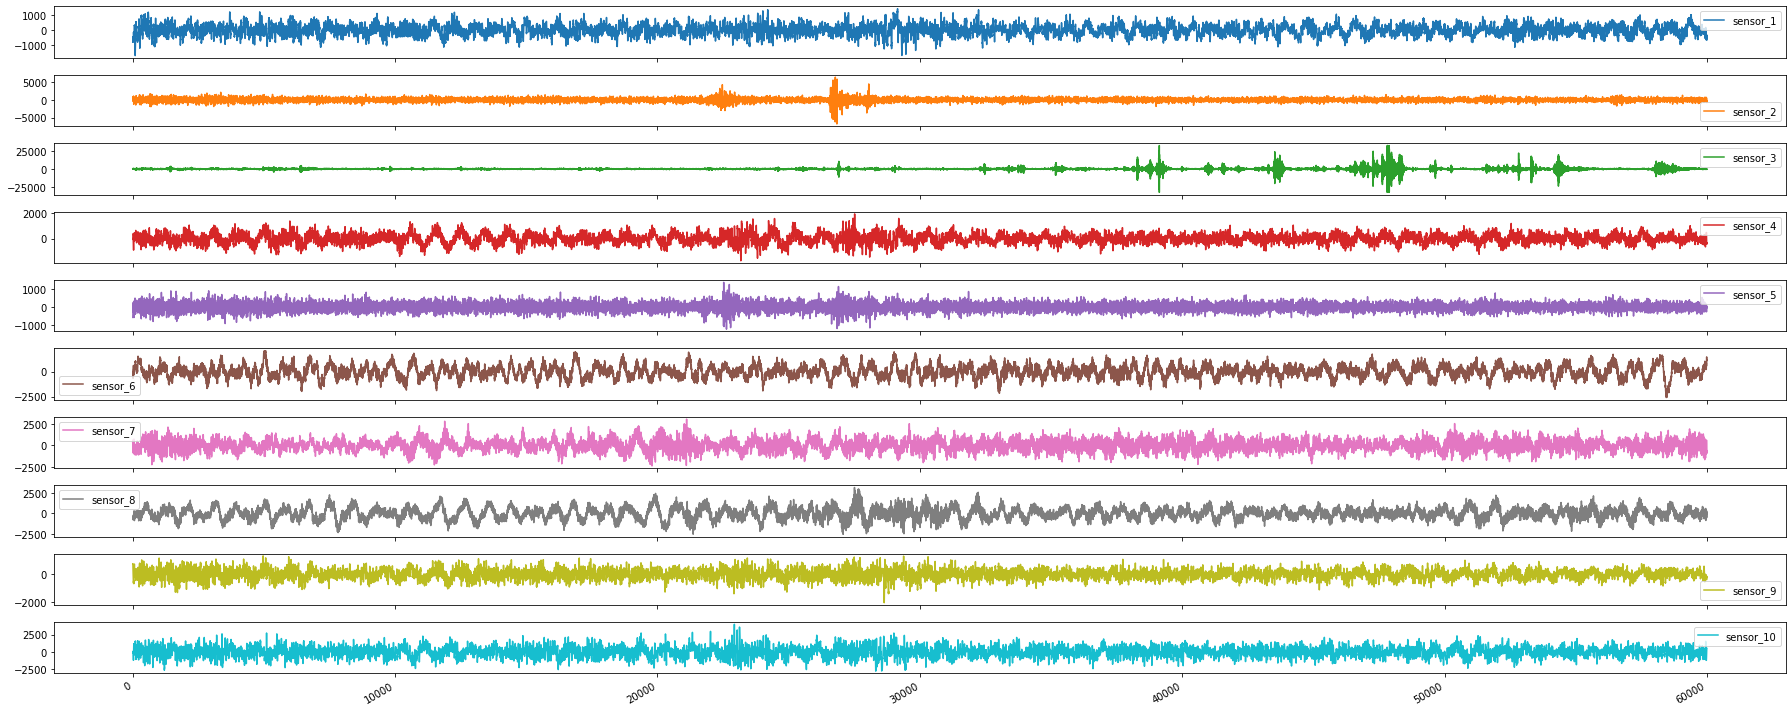

In [13]:
segment.fillna(0).plot(subplots=True, figsize=(25, 10))
plt.tight_layout()
plt.show()

Merge data for train/test

In [ ]:
train_segmnets = glob.glob(os.path.join(train_data_path,"*.csv"))
test_segmnets = glob.glob(os.path.join(test_data_path,"*.csv"))

train_segmnets

In [ ]:
#lst_of_segments_data = []
#lst_of_segments_number = []
#read each segment and save inside li
#for filename in train_segmnets:
#    df = pd.read_csv(filename, index_col=None, header=0)
#    lst_of_segments_data.append(df)
#    lst_of_segments_number.append(int((filename.split('/')[-1])[:-4]))
#lst_of_segments_data[1]
#frame = pd.concat(li, axis=0, ignore_index=True)
#frame


Random sample data and split for training and test
for internal using

In [54]:
#sampling with replacement
sampling_segmentID = random.choices(train_segmnets, k=sample_size )
sampling_segmentID


['./gdrive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/train/967094967.csv',
 './gdrive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/train/1814907428.csv',
 './gdrive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/train/1897117523.csv',
 './gdrive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/train/1529424839.csv',
 './gdrive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/train/573797974.csv',
 './gdrive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/train/1000745424.csv',
 './gdrive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/train/1964629036.csv',
 './gdrive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/train/247768640.csv',
 './gdrive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/train/2079951456.csv',
 './gdrive/MyDrive/Kaggle/predict-volcanic-eruptions-ingv-oe/train/993045904.csv']

In [55]:
sampling_segmentID = [int(x.split('/')[-1][:-4]) for x in sampling_segmentID]
sampling_segmentID

[967094967,
 1814907428,
 1897117523,
 1529424839,
 573797974,
 1000745424,
 1964629036,
 247768640,
 2079951456,
 993045904]

In [ ]:
#Calculate x_train,y_train,x_test,y_test

y_train =[]
x_train = []
x_test = []
y_test = []
counter = 0
for seg in sampling_segmentID:## 3 test 7 train
  if counter <3:
    y_test.append(train_dic[seg])
    tmpDf = pd.read_csv(train_data_path+str(seg)+".csv", index_col=None, header=0)
    mean_per_collumn = tmpDf.mean(axis = 0).fillna(tmpDf.mean(axis = 0).mean())
    x_test.append(np.array(a))
    counter = counter +1
  else:
    y_train.append(train_dic[seg])
    tmpDf = pd.read_csv(train_data_path+str(seg)+".csv", index_col=None, header=0)
    mean_per_collumn = tmpDf.mean(axis = 0).fillna(tmpDf.mean(axis = 0).mean())
    x_train.append(np.array(a))


Logistic regression

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [104]:
poly_model = make_pipeline(PolynomialFeatures(10),
                           LinearRegression())
poly_model.fit(x_train, y_train)
yfit = poly_model.predict(x_test)
mae = mean_absolute_error( y_test,yfit)
mae
#3843230 - 1 place
#11598807 - Our result

11598807.333333334

Plynomial Feature